In [237]:
import numpy as np
import glob
import os
%pylab inline --no-import-all
# plt.rc('font', family='serif', serif='Times', size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure', titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
cmap = 'inferno'  # 'gray_r'

Populating the interactive namespace from numpy and matplotlib


# Load data

In [238]:
os.chdir('/Users/mrizzo/IFS/crispy/crispy/HCIFS/')
from params import Params
par = Params()

fname = par.wavecalDir+'channel05_flat(1).fits'
data = fits.getdata(fname)

# Show histogram

(-10, 50)

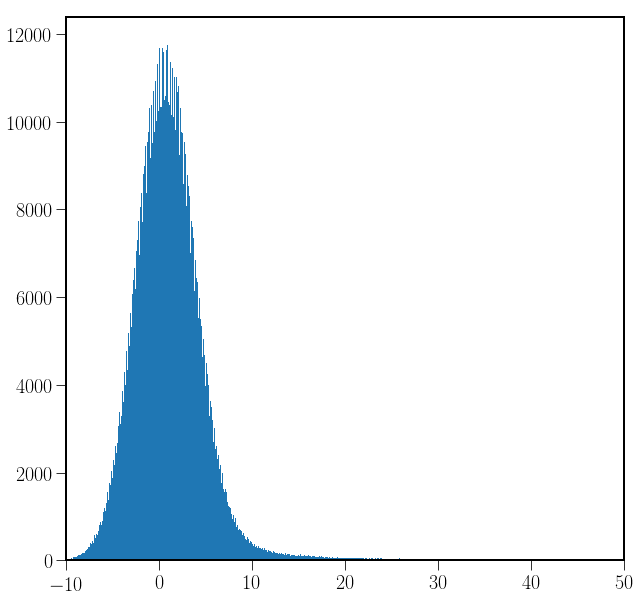

In [239]:
plt.figure(figsize=(10,10))
plt.hist(np.reshape(data,-1),bins='auto')
plt.xlim([-10,50])

# Extract stars with crispy wavecal centroids

## Find the centroids

In [240]:
lamsol = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]
log.info(lamsol)
log.info(allcoef[4])

main - INFO - [550.  577.  600.  620.  632.8 640.  650.  670.  694.3 720.  740. ]
main - INFO - [ 5.28699303e+02  1.21103371e+01 -2.66977922e-02  5.18853952e-05
 -5.82616628e+00  7.66217760e-03 -3.77157241e-05 -2.04574213e-02
  4.59146323e-05 -1.89136158e-05  5.13458898e+02  6.02230589e+00
  6.97245896e-05  1.67325729e-06  1.19043451e+01 -5.80152814e-05
  6.60126760e-07  1.99188871e-04  1.00529545e-06  2.49811677e-06]


In [88]:
from crispy.tools.locate_psflets import PSFLets,transform

xindx = np.arange(-par.nlens // 2, par.nlens // 2)
xindx, yindx = np.meshgrid(xindx, xindx)

psftool = PSFLets()
psftool.geninterparray(lamsol, allcoef)
x,y = psftool.return_locations(lamsol[4], allcoef, xindx, yindx)
x,y = transform(xindx, yindx, 3, allcoef[4])
print(x[par.nlens//2,par.nlens//2+1])
print(y[par.nlens//2,par.nlens//2+1])

516.5622159946337
507.4366605295757


/Users/mrizzo/anaconda2/envs/py36/lib/python3.6/site-packages/crispy-0.9-py3.6.egg/crispy/tools/locate_psflets.py:135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(xarr, allcoef[:, i])[0]


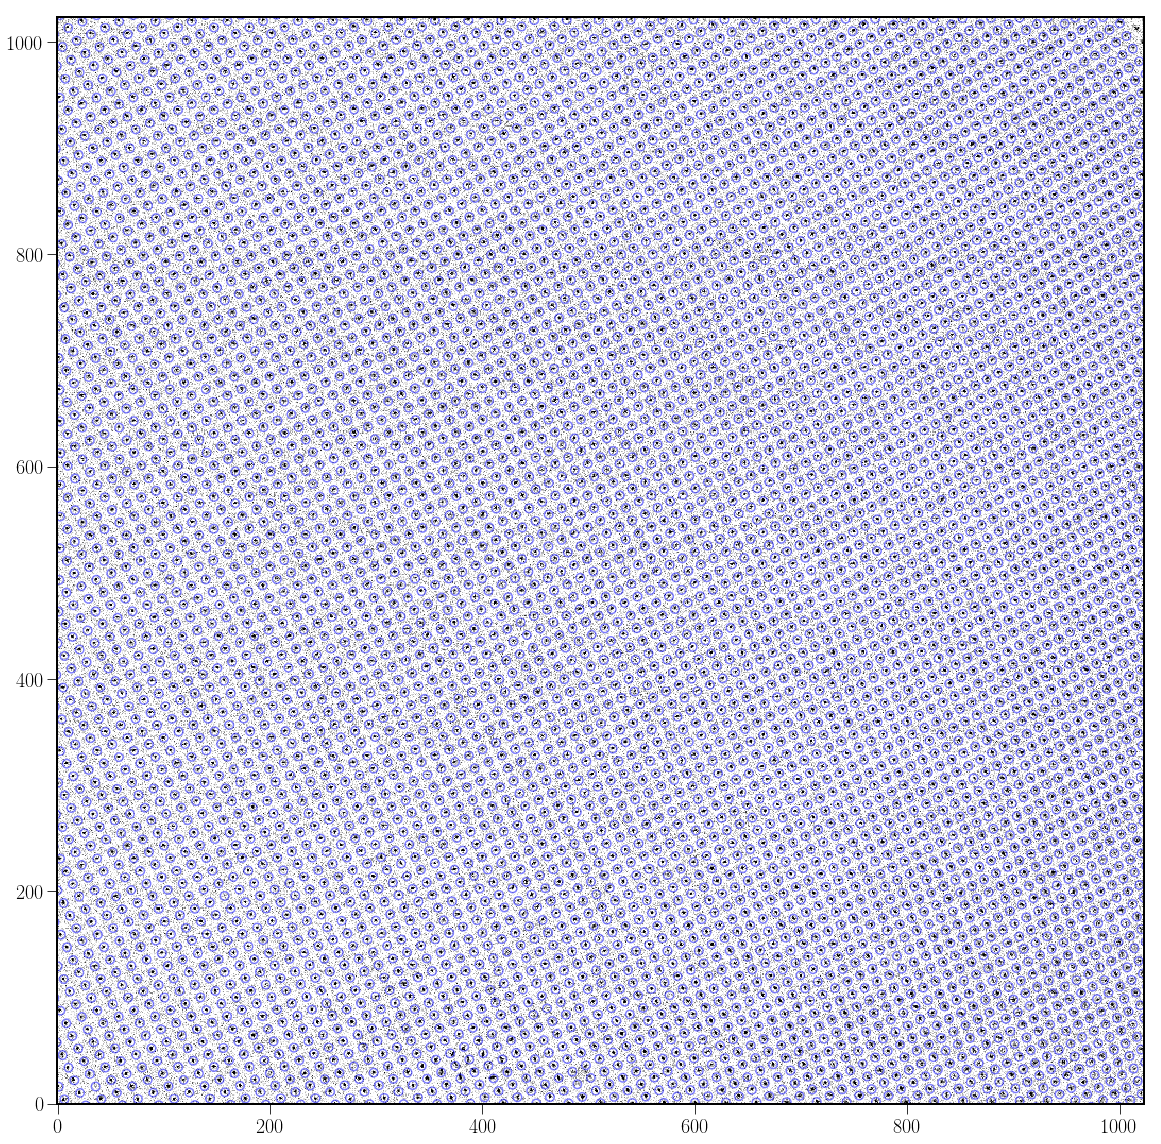

In [91]:
positions = (np.reshape(x,-1), np.reshape(y,-1))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0,vmax=5*std_val)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

## Use Photutils to extract stars

In [93]:
stars_tbl = Table()
stars_tbl['x'] = np.reshape(x,-1)
stars_tbl['y'] = np.reshape(y,-1)
from astropy.nddata import NDData
nddata = NDData(data=data)
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=12)

        x                  y         
----------------- -------------------
67.70948337773535  -454.8843595442451
63.65140806274079  -442.9690100094008
59.55347365465954  -431.0541650698567
55.41556667179646  -419.1398097369124
51.23757363245665  -407.2259290218671
47.01938105494504 -395.31250793602044
42.76087545756673 -383.39953149067156
38.46194335862659  -371.4869846971197
34.12247127642974 -359.57485256666456
29.74234572928109 -347.66312011060523
              ...                 ...
828.0169117569394  1327.6020334796565
820.8487643728633  1339.5400584858648
813.6395975550231  1351.4792309346694
806.3892978217243   1363.419565814771
799.0977516912718   1375.361078114869
791.7648456819707  1387.3037828236656
784.3904663121256  1399.2476949298607
776.9745001000421  1411.1928294221548
769.5168335640244  1423.1392012892488
762.0173532223783   1435.086825519843
754.4759455934085  1447.0357171026383
Length = 11449 rows


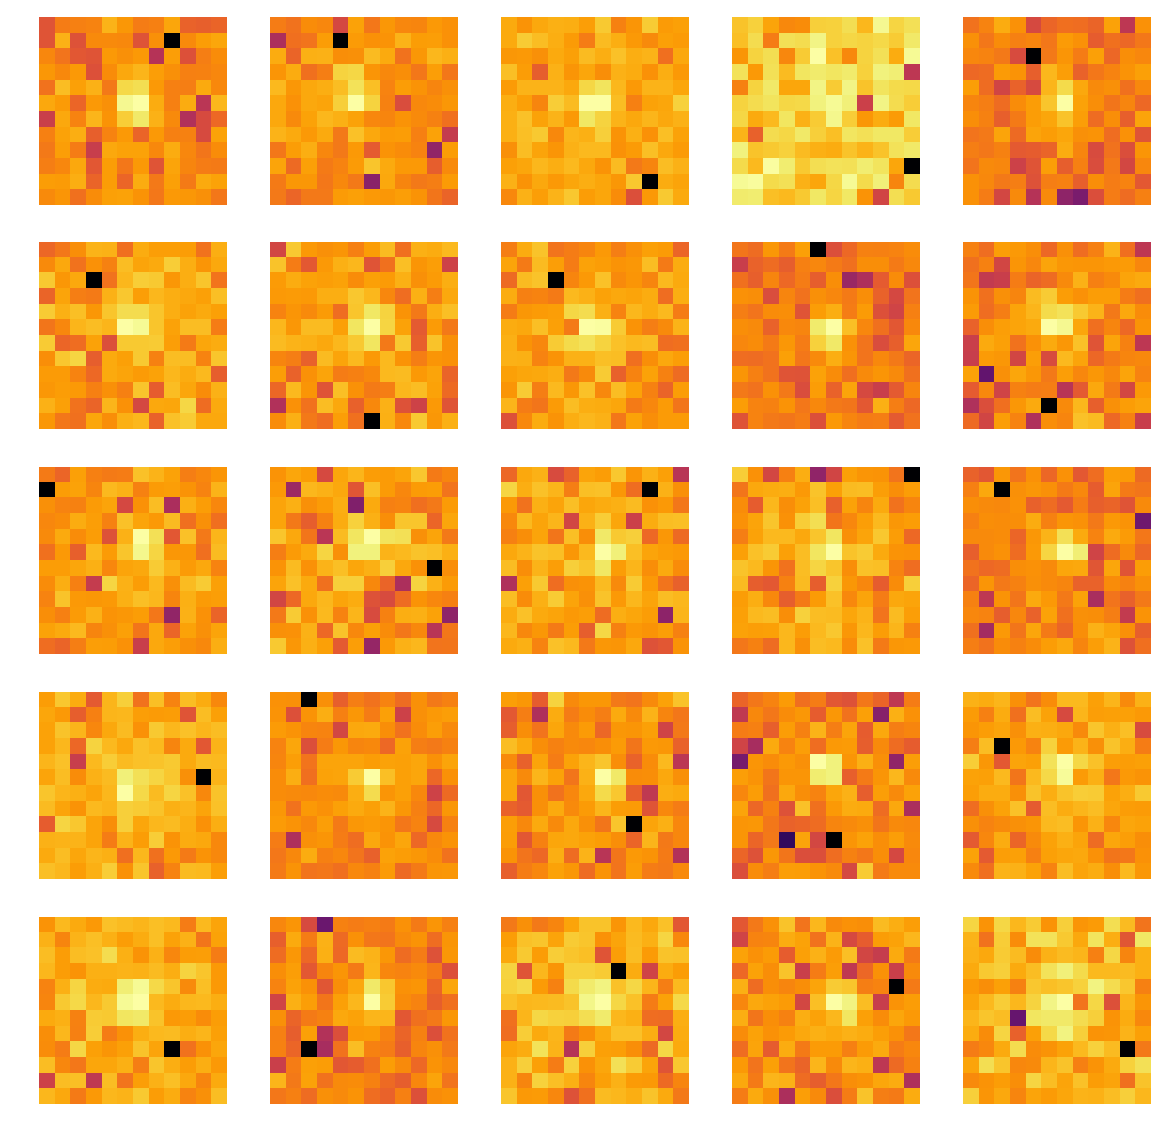

In [94]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.9)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap=cmap)
    ax[i].axis('off')

# Compute high-resolution PSFlets

In [146]:
nsubarr=4
npix=13
upsample=3
x = np.reshape(x,-1)
y = np.reshape(y,-1)
from photutils import EPSFBuilder
from astropy.nddata import NDData
from photutils.psf import extract_stars
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

hires_arr = np.zeros((nsubarr, nsubarr, upsample * npix, upsample * npix))

for yreg in range(nsubarr):
    i1 = yreg * data.shape[0] // nsubarr
    i2 = i1 + data.shape[0] // nsubarr
    i1 = max(i1, npix)
    i2 = min(i2, data.shape[0] - npix)

    for xreg in range(nsubarr):
        j1 = xreg * data.shape[1] // nsubarr
        j2 = j1 + data.shape[1] // nsubarr
        j1 = max(j1, npix)
        j2 = min(j2, data.shape[1] - npix)

        mask = (x>j1)*(x<j2)*(y>i1)*(y<i2)
        xcoord = x[mask]
        ycoord = y[mask]
        stars_tbl = Table()
        stars_tbl['x'] = xcoord
        stars_tbl['y'] = ycoord
        nddata = NDData(data=data)
        stars = extract_stars(nddata, stars_tbl, size=npix)
        
        epsf_builder = EPSFBuilder(oversampling=3, maxiters=4,
                                   progress_bar=True)
        epsf, fitted_stars = epsf_builder(stars)
        hires_arr[yreg,xreg] = epsf.data
#         norm = simple_norm(epsf.data, 'linear', percent=99.)
#         epsf.data[epsf.data<0.0]=0.0
#         plt.imshow(epsf.data, origin='lower', cmap=cmap, norm=norm)
#         plt.colorbar()

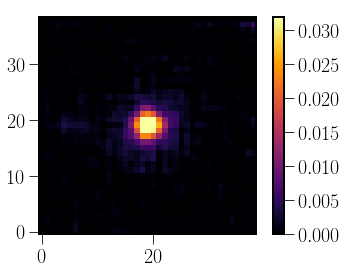

In [140]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'linear', percent=99.)
epsf.data[epsf.data<0.0]=0.0
plt.imshow(epsf.data, origin='lower', cmap=cmap, norm=norm)
plt.colorbar()

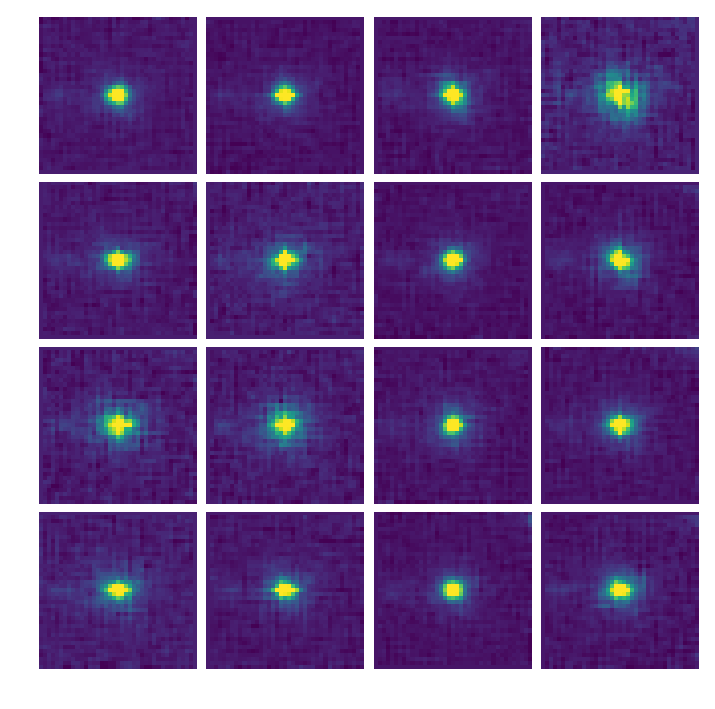

In [147]:
fig, axarr = plt.subplots(nsubarr,nsubarr,figsize=(12,12))
for i in range(hires_arr.shape[0]):
    for j in range(hires_arr.shape[1]):
        dat = hires_arr[i,j]
        norm = simple_norm(dat, 'linear', percent=99.)
        axarr[i,j].imshow(dat,norm=norm)
        axarr[i,j].axis('off')
plt.subplots_adjust(wspace=0.0,hspace=0.05)

# Calculate SNR for all PSFlets

In [241]:
from crispy.tools.locate_psflets import PSFLets,transform

xindx = np.arange(-par.nlens // 2, par.nlens // 2)
xindx, yindx = np.meshgrid(xindx, xindx)

psftool = PSFLets()
psftool.geninterparray(lamsol, allcoef)
x,y = psftool.return_locations(lamsol[4], allcoef, xindx, yindx)
x,y = transform(xindx, yindx, 3, allcoef[4])
print(x[par.nlens//2,par.nlens//2+1])
print(y[par.nlens//2,par.nlens//2+1])

from photutils import aperture_photometry
# mask = (x>0)*(x<data.shape[0])*(y>0)*(y<data.shape[0])
xcoords = np.reshape(x,-1)
ycoords = np.reshape(y,-1)

positions = (xcoords,ycoords)
ap = CircularAperture(positions, r=2.)


phot_table = aperture_photometry(data, ap)

/Users/mrizzo/anaconda2/envs/py36/lib/python3.6/site-packages/crispy-0.9-py3.6.egg/crispy/tools/locate_psflets.py:135: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = np.linalg.lstsq(xarr, allcoef[:, i])[0]


516.5622159946337
507.4366605295757


In [242]:
print(phot_table)
print(xcoords[0],ycoords[0])

  id       xcenter            ycenter       aperture_sum
             pix                pix                     
----- ----------------- ------------------- ------------
    1 67.70948337773535  -454.8843595442451          nan
    2 63.65140806274079  -442.9690100094008          nan
    3 59.55347365465954  -431.0541650698567          nan
    4 55.41556667179646  -419.1398097369124          nan
    5 51.23757363245665  -407.2259290218671          nan
    6 47.01938105494504 -395.31250793602044          nan
    7 42.76087545756673 -383.39953149067156          nan
    8 38.46194335862659  -371.4869846971197          nan
    9 34.12247127642974 -359.57485256666456          nan
   10 29.74234572928109 -347.66312011060523          nan
  ...               ...                 ...          ...
11440 820.8487643728633  1339.5400584858648          nan
11441 813.6395975550231  1351.4792309346694          nan
11442 806.3892978217243   1363.419565814771          nan
11443 799.0977516912718   1375.

(11449,)
(107, 107)


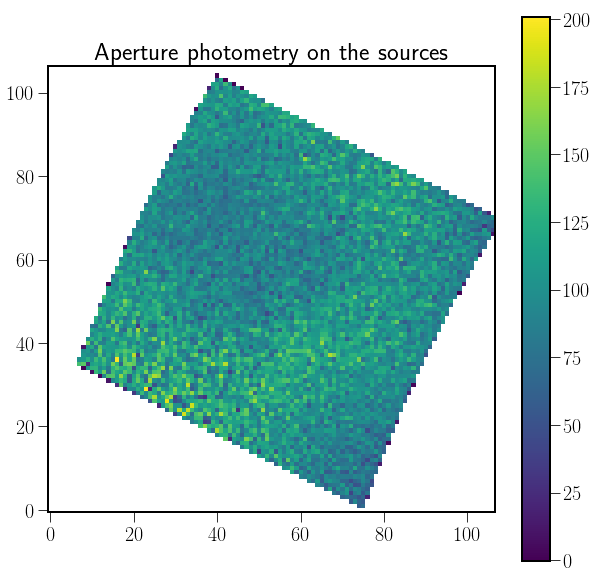

In [243]:
phot = np.array(phot_table['aperture_sum'])
print(phot.shape)
print(x.shape)
p = phot.reshape((par.nlens,par.nlens))
# for i in range(xindx.shape[0]):
#     for j in range(xindx.shape[1]):
#         if ~mask[i,j]:
#             phot_img
plt.figure(figsize=(10,10))
plt.imshow(p.T)
plt.title('Aperture photometry on the sources',fontsize=25)
plt.colorbar()

In [244]:
from photutils import CircularAnnulus
r_in = 5
r_out = 8
bkg_ap = CircularAnnulus(ap.positions,r_in=r_in, r_out=r_out)
bkd_area = bkg_ap.area()
print(bkd_area)
mask=None

# Run photometry
flux_tbl = aperture_photometry(data, ap)

# find rms within annulus
annulus_masks = bkg_ap.to_mask(method='center')

flux_tbl['bkgrms'] = np.NaN
flux_tbl['bkgmean'] = np.NaN
flux_tbl['bkgmed'] = np.NaN

aparea = ap.area()

for i in range(len(annulus_masks)):
    if (flux_tbl['xcenter'][i].value>r_out) and \
        (flux_tbl['xcenter'][i].value<data.shape[0]-r_out) and \
        (flux_tbl['ycenter'][i].value>r_out) and \
        (flux_tbl['ycenter'][i].value<data.shape[1]-r_out):
        annulus_data = annulus_masks[i].multiply(data)
        mask = annulus_masks[0].data
        annulus_data_1d = annulus_data[mask > 0]
        mean, median, rms = sigma_clipped_stats(annulus_data_1d)
        flux_tbl['bkgrms'][i] = rms * np.sqrt(aparea)
        flux_tbl['bkgmean'][i] = mean * aparea
        flux_tbl['bkgmed'][i] = median * aparea


122.52211349000193


(11449,)
(107, 107)


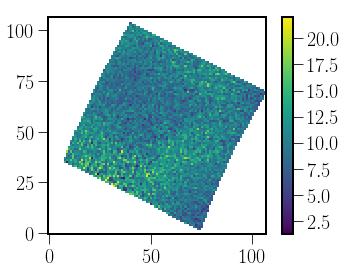

In [247]:
phot = np.array(flux_tbl['aperture_sum'] - flux_tbl['bkgmed'])/np.array(flux_tbl['bkgrms'])
# phot = np.array(flux_tbl['rmslist'])
print(phot.shape)
print(x.shape)
p = phot.reshape((par.nlens,par.nlens))
plt.imshow(p.T)
plt.colorbar()

(11449,)
(107, 107)


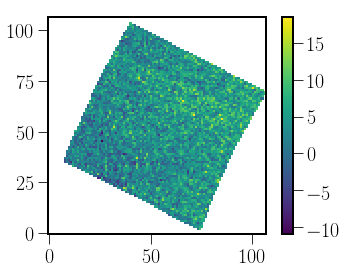

In [248]:
phot = np.array(flux_tbl['bkgmean'])
# phot = np.array(flux_tbl['rmslist'])
print(phot.shape)
print(x.shape)
p = phot.reshape((par.nlens,par.nlens))
plt.imshow(p.T)
plt.colorbar()